In [1]:
from threshold_regression import *

from adios2toolspy import SuperCell, BpParticles, BpFields
from h5toolspy import H5Processor
from picplot import fieldGrid, histGrid
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline 
plt.rcParams['figure.figsize'] = [16, 8]

In [2]:
root = '/mnt/lustre/germaschewski/jca32/psc/build/smallRun2/'
dt = 0.175009  
dx= 0.25 #dx/de 
dy, dz = 4, 0.25 # dy/de, dz/de 

In [3]:
def averaging(arr):
    x, y = arr.shape
    arr = np.pad(arr, ((1,1), (1,1)))
    temp = np.zeros((x,y))
    for i in range(x):
        for j in range(y):
            temp[i,j] = (arr[i,j] + arr[i+1,j] + arr[i-1,j] + arr[i,j+1] + arr[i,j-1] + arr[i-1,j-1] + arr[i-1,j+1] + arr[i+1,j-1] + arr[i+1,j+1])/9
    return temp

def fc_to_nc(x, dim='x'):
    h, w = x.shape
    tmp = np.zeros((h,w))
    if dim == 'x':
        tmp[1:,:] = 0.5*(x[:-1,:] + x[1:,:])
    elif dim == 'y':
        tmp[1:,1:] = 0.25*(x[1:,1:] + x[:-1,1:] + x[1:,:-1] + x[:-1,:-1])
    else: #'z'
        tmp[:,1:] = 0.5*(x[:,:-1] + x[:,1:])

    return tmp

def ec_to_nc(x, dim='x'):
    h, w = x.shape
    tmp = np.zeros((h,w))
    if dim == 'x':
        tmp[:,1:] = 0.5*(x[:,1:] + x[:,:-1])
    if dim == 'y':
        return x
    else: # z
        tmp[1:,:] = 0.5*(x[1:,:] + x[:-1,:])
    return tmp

In [249]:
h5p = H5Processor(root, timeAveraged=False)
time = -20
tstep = 1
cut = 20

prep = lambda x, t: averaging(h5p.getH5Grid(x, t).data[:,0,:])[cut:-cut, cut:-cut].flatten()


bx = h5p.getH5Grid('hx_fc', time).data[:,0,:]
by = h5p.getH5Grid('hy_fc', time).data[:,0,:]
bz = h5p.getH5Grid('hz_fc', time).data[:,0,:]

Bx = averaging(fc_to_nc(bx, dim='x'))[cut:-cut,cut:-cut].flatten()
By = averaging(fc_to_nc(by, dim='y'))[cut:-cut,cut:-cut].flatten()
Bz = averaging(fc_to_nc(bz, dim='z'))[cut:-cut,cut:-cut].flatten()

pxx = prep('txx_nc_e', time)
pxy = prep('txy_nc_e', time)
pxz = prep('tzx_nc_e', time)
pyy = prep('tyy_nc_e', time)
pyz = prep('tyz_nc_e', time)
pzz = prep('tzz_nc_e', time)

zshape, xshape = bz.shape
zshape -= 2*cut
xshape -= 2*cut

Loading hx_fc from File: pfd.002366.xdmf
Loading hy_fc from File: pfd.002366.xdmf
Loading hz_fc from File: pfd.002366.xdmf
Loading txx_nc_e from File: pfd.002366.xdmf
Loading txy_nc_e from File: pfd.002366.xdmf
Loading tzx_nc_e from File: pfd.002366.xdmf
Loading tyy_nc_e from File: pfd.002366.xdmf
Loading tyz_nc_e from File: pfd.002366.xdmf
Loading tzz_nc_e from File: pfd.002366.xdmf


In [250]:
b_norm = np.sqrt(Bx**2 + By**2 + Bz**2)
b_x = Bx/b_norm
b_y = By/b_norm
b_z = Bz/b_norm

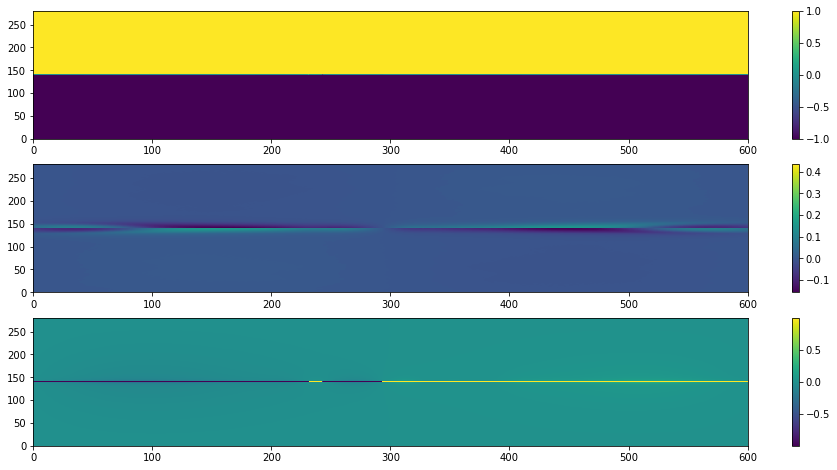

In [251]:
fig, axes = plt.subplots(3,1)
pcm0 = axes[0].pcolormesh(b_x.reshape(zshape, xshape))
pcm1 = axes[1].pcolormesh(b_y.reshape(zshape, xshape))
pcm2 = axes[2].pcolormesh(b_z.reshape(zshape, xshape))
fig.colorbar(pcm0, ax=axes[0])
fig.colorbar(pcm1, ax=axes[1])
fig.colorbar(pcm2, ax=axes[2])

In [252]:
B_par = np.vstack((b_x, b_y, b_z)).T

In [253]:
#Gram-Schmidt orthoganlization with random vector. third is from cross product
bshape_m, bshape_n = B_par.shape
# v1 = np.random.randn(bshape_m, bshape_n)
v1 = np.zeros((bshape_m, bshape_n))
# v1[:,0] = 1
v1[:,1] = 1
# v1[:,2] = 1
B_perp1 = v1 - np.sum(v1*B_par, -1).reshape(-1,1)*B_par
B_perp1 /= np.linalg.norm(B_perp1, axis=-1).reshape(-1,1)
B_perp2 = np.cross(B_par, B_perp1)
B_perp2 /= np.linalg.norm(B_perp2, axis=-1).reshape(-1,1)

In [254]:
#orthogonal check
np.sum(B_perp1*B_par), np.sum(B_perp2*B_par), np.sum(B_perp1*B_perp2)

(-1.113258790708116e-15, 4.831204880595408e-16, 8.086166149645288e-16)

In [255]:
#normalized check
np.linalg.norm(B_par, axis=-1).sum()/B_par.shape[0], np.linalg.norm(B_perp1, axis=-1).sum()/B_perp1.shape[0], np.linalg.norm(B_perp2, axis=-1).sum()/B_perp2.shape[0]

(1.0, 1.0, 1.0)

In [256]:
B_matrix = np.stack((B_par, B_perp1, B_perp2), -1)
B_matrix.shape

(168000, 3, 3)

In [257]:
P_matrix_x = np.stack((pxx, pxy, pxz), -1)
P_matrix_y = np.stack((pxy, pyy, pyz), -1)
P_matrix_z = np.stack((pxz, pyz, pzz), -1)
P_matrix = np.stack((P_matrix_x, P_matrix_y, P_matrix_z), -1)
P_matrix_img = P_matrix.reshape(zshape,xshape,3,3)

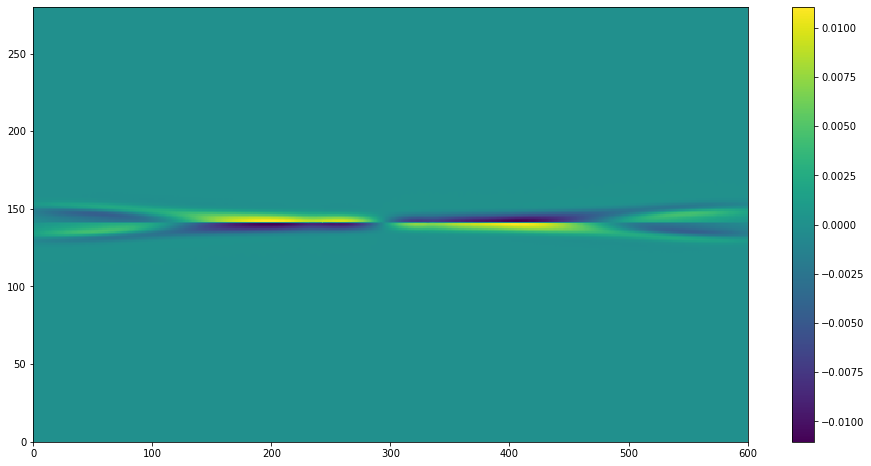

In [333]:
plt.pcolormesh(P_rotated_img[...,1,2])
plt.colorbar()

In [258]:
#unitary check
np.allclose(np.eye(3), (np.transpose(B_matrix, (0,2,1))@B_matrix))

True

In [259]:
P_rotated = np.transpose(B_matrix, (0,2,1))@P_matrix@B_matrix

In [260]:
P_rotated_img = P_rotated.reshape(zshape,xshape,3,3)

9.167892084212357e-16

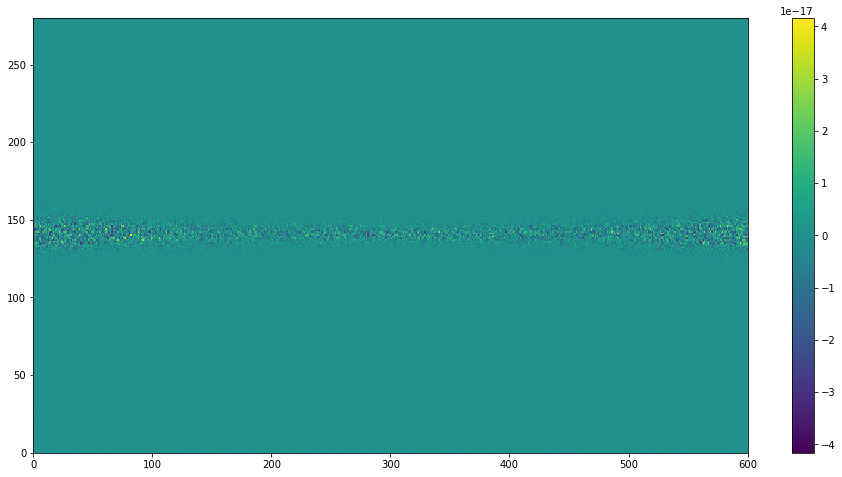

In [261]:
## check that trace of rotated equals original Pressure 
plt.pcolormesh((P_matrix[:,0,0] + P_matrix[:,1,1] + P_matrix[:,2,2]).reshape(zshape,xshape) - (P_rotated[:,0,0] + P_rotated[:,1,1] + P_rotated[:,2,2]).reshape(zshape,xshape))
plt.colorbar()
np.linalg.norm((P_matrix[:,0,0] + P_matrix[:,1,1] + P_matrix[:,2,2]) - (P_rotated[:,0,0] + P_rotated[:,1,1] + P_rotated[:,2,2]))

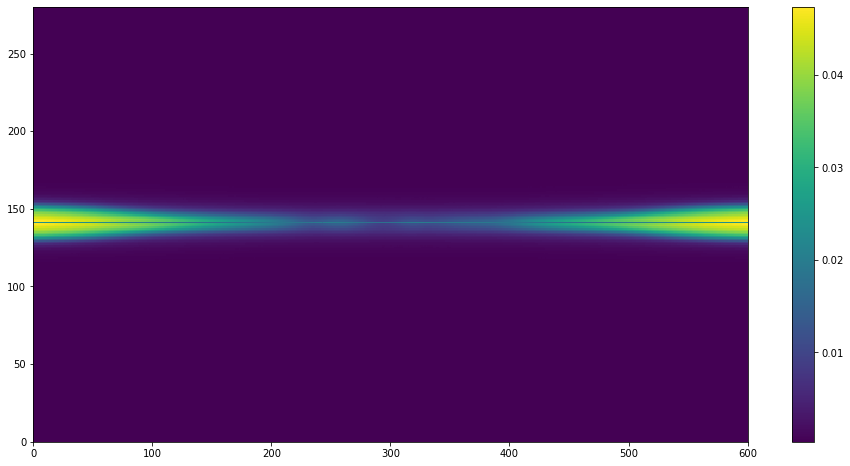

In [262]:
#p_par
plt.pcolormesh(P_rotated_img[..., 0,0])
plt.colorbar()

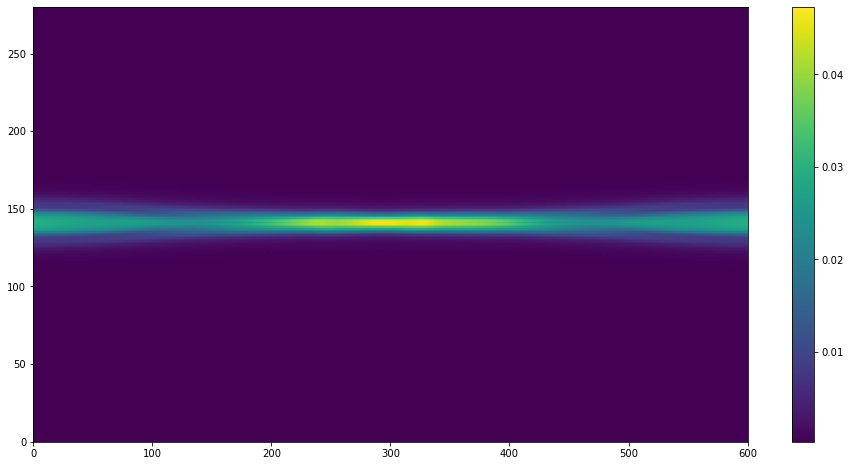

In [263]:
#p_perp1
plt.pcolormesh(P_rotated_img[..., 1,1])
plt.colorbar()

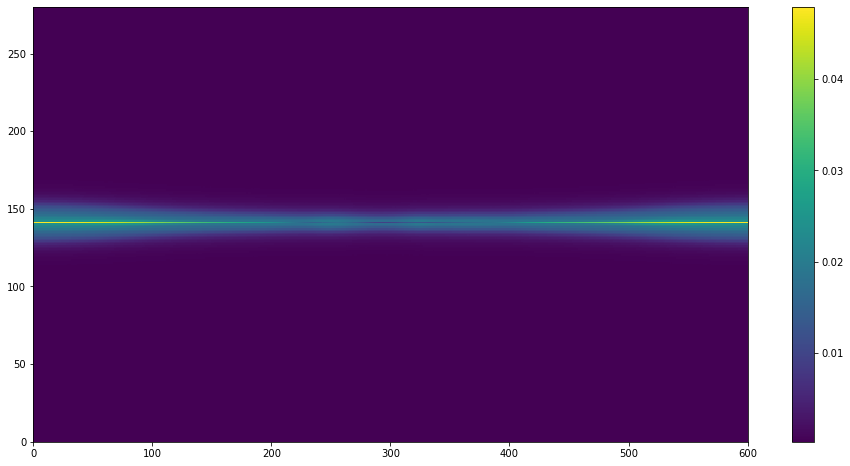

In [264]:
#p_perp2
plt.pcolormesh(P_rotated_img[..., 2,2])
plt.colorbar()

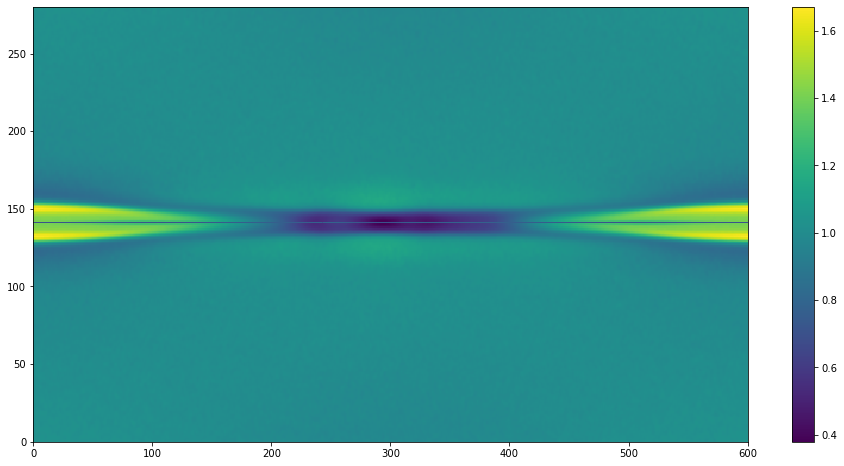

In [265]:
#anisotropy ratio
P_avg = 1/3*(pxx + pyy + pzz).reshape(zshape, xshape)
plt.pcolormesh(P_rotated_img[..., 0,0]/P_avg)
plt.colorbar()

In [266]:
#Swisdak 2016 off diagonal check, Eqn #5
(P_rotated[:,0,1]**2 < P_rotated[:,0,0]*P_rotated[:,1,1]).all(), (P_rotated[:,0,2]**2 < P_rotated[:,0,0]*P_rotated[:,1,1]).all(),(P_rotated[:,1,2]**2 < P_rotated[:,1,1]*P_rotated[:,1,1]).all()

(True, True, True)

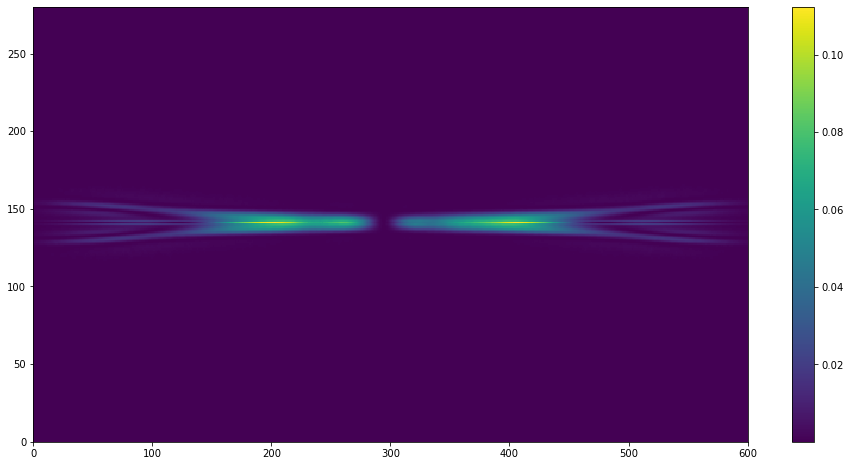

In [267]:
Q = (P_rotated[:,0,1]**2 + P_rotated[:,0,2]**2 + P_rotated[:,1,2]**2) / (P_rotated[:,0,0]**2 + 2*P_rotated[:,1,1]*P_rotated[:,0,0])
plt.pcolormesh(Q.reshape(zshape,xshape))
plt.colorbar()

In [268]:
qxxx = averaging(h5p.getH5Grid('qxxx_nc_e', time).data[:,0,:])
qxxz = averaging(h5p.getH5Grid('qxxz_nc_e', time).data[:,0,:])
qyyx = averaging(h5p.getH5Grid('qyyx_nc_e', time).data[:,0,:])
qyyz = averaging(h5p.getH5Grid('qyyz_nc_e', time).data[:,0,:])
qzzx = averaging(h5p.getH5Grid('qzzx_nc_e', time).data[:,0,:])
qzzz = averaging(h5p.getH5Grid('qzzz_nc_e', time).data[:,0,:])
qxyx = averaging(h5p.getH5Grid('qxxy_nc_e', time).data[:,0,:])
qxyz = averaging(h5p.getH5Grid('qxyz_nc_e', time).data[:,0,:])
qxzx = qxxz
qxzz = qzzx
qyzx = qxyz
qyzz = averaging(h5p.getH5Grid('qzzy_nc_e', time).data[:,0,:])

n = -prep('rho_nc_e', time).reshape(zshape,xshape)

Loading qxxx_nc_e from File: pfd.002366.xdmf
Loading qxxz_nc_e from File: pfd.002366.xdmf
Loading qyyx_nc_e from File: pfd.002366.xdmf
Loading qyyz_nc_e from File: pfd.002366.xdmf
Loading qzzx_nc_e from File: pfd.002366.xdmf
Loading qzzz_nc_e from File: pfd.002366.xdmf
Loading qxxy_nc_e from File: pfd.002366.xdmf
Loading qxyz_nc_e from File: pfd.002366.xdmf
Loading qzzy_nc_e from File: pfd.002366.xdmf
Loading rho_nc_e from File: pfd.002366.xdmf


In [269]:
d_qxxx_dx = (np.diff(qxxx, axis=1, append=0) + np.diff(qxxx, axis=1, append=0)) / dx / 2
d_qxxz_dz = (np.diff(qxxz, axis=0, append=0) + np.diff(qxxz, axis=0, append=0)) / dz / 2
div_qxx = (d_qxxx_dx + d_qxxz_dz)[cut:-cut,cut:-cut]

d_qyyx_dx = (np.diff(qyyx, axis=1, prepend=0) + np.diff(qyyx, axis=1, append=0)) / dx / 2
d_qyyz_dz = (np.diff(qyyz, axis=0, prepend=0) + np.diff(qyyz, axis=0, append=0)) / dz / 2
div_qyy = (d_qyyx_dx + d_qyyz_dz)[cut:-cut,cut:-cut]

d_qzzx_dx = (np.diff(qzzx, axis=1, prepend=0) + np.diff(qzzx, axis=1, append=0)) / dx / 2
d_qzzz_dz = (np.diff(qzzz, axis=0, prepend=0) + np.diff(qzzz, axis=0, append=0)) / dz / 2
div_qzz = (d_qzzx_dx + d_qzzz_dz)[cut:-cut,cut:-cut]

d_qxyx_dx = (np.diff(qxyx, axis=1, prepend=0) + np.diff(qxyx, axis=1, append=0)) / dx / 2
d_qxyz_dz = (np.diff(qxyz, axis=0, prepend=0) + np.diff(qxyz, axis=0, append=0)) / dz / 2
div_qxy = (d_qxyx_dx + d_qxyz_dz)[cut:-cut,cut:-cut]

d_qxzx_dx = (np.diff(qxzx, axis=1, prepend=0) + np.diff(qxzx, axis=1, append=0)) / dx / 2
d_qxzz_dz = (np.diff(qxzz, axis=0, prepend=0) + np.diff(qxzz, axis=0, append=0)) / dz / 2
div_qxz = (d_qxzx_dx + d_qxzz_dz)[cut:-cut,cut:-cut]

d_qyzx_dx = (np.diff(qyzx, axis=1, prepend=0) + np.diff(qyzx, axis=1, append=0)) / dx / 2
d_qyzz_dz = (np.diff(qyzz, axis=0, prepend=0) + np.diff(qyzz, axis=0, append=0)) / dz / 2
div_qyz = (d_qyzx_dx + d_qyzz_dz)[cut:-cut,cut:-cut]

vt = 0.14

In [270]:
ux = averaging(h5p.getH5Grid('px_nc_e', time).data[:,0,:])[cut:-cut,cut:-cut]
Pxxx = pxx.reshape(zshape,xshape) - n*ux*ux
uy = averaging(h5p.getH5Grid('py_nc_e', time).data[:,0,:])[cut:-cut,cut:-cut]
Pyyy = pyy.reshape(zshape,xshape) - n*uy*uy
uz = averaging(h5p.getH5Grid('pz_nc_e', time).data[:,0,:])[cut:-cut,cut:-cut]
Pzzz = pzz.reshape(zshape,xshape) - n*uz*uz

Loading px_nc_e from File: pfd.002366.xdmf
Loading py_nc_e from File: pfd.002366.xdmf
Loading pz_nc_e from File: pfd.002366.xdmf


0.0016396272602274768

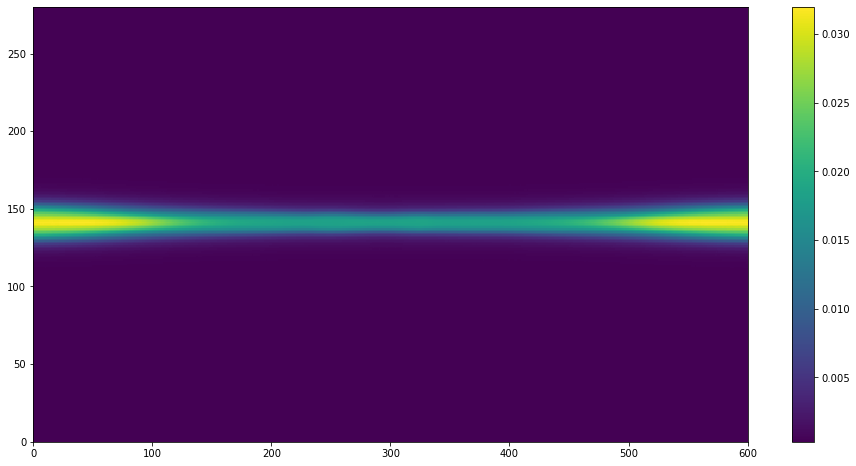

In [271]:
P_avg_bulk = 1/3*(Pxxx+Pyyy+Pzzz)
plt.pcolormesh(P_avg_bulk)
plt.colorbar()
P_avg_bulk.mean()

In [272]:
P_closure_x = P_matrix_img[...,0,0] - P_avg
P_closure_y = P_matrix_img[...,1,1] - P_avg
P_closure_z = P_matrix_img[...,2,2] - P_avg

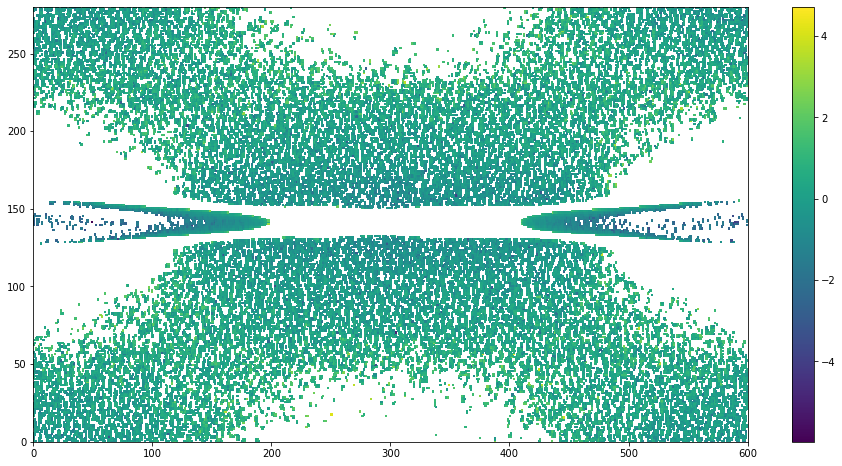

In [273]:
k_0 = np.log10(div_qxx+1e-10)- np.log10(vt*P_closure_x+1e-10)
plt.pcolormesh(k_0)
plt.colorbar()
k = div_qxx.reshape(zshape,xshape) / (vt*P_closure_x)
k = k[np.logical_not(np.isnan(k))].mean()

1

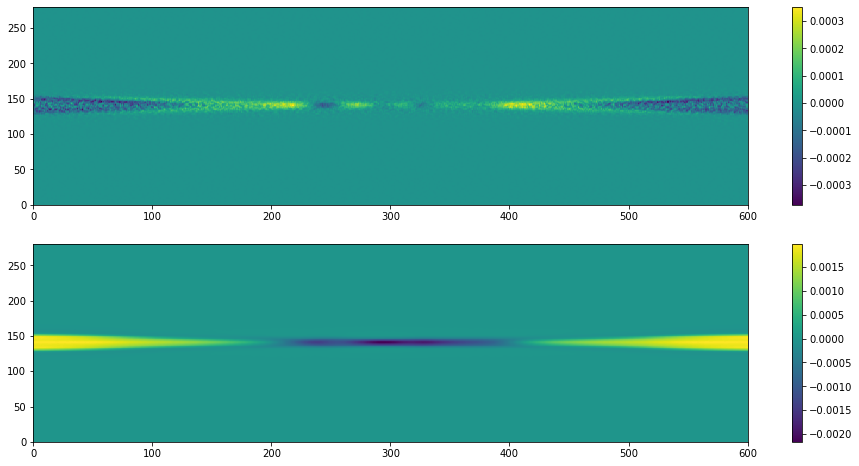

In [324]:
fig, axes = plt.subplots(2,1)
pcm0 = axes[0].pcolormesh(div_qxx)
fig.colorbar(pcm0, ax=axes[0])
# k=-0.015
pcm1 = axes[1].pcolormesh(vt*k*P_closure_x)
fig.colorbar(pcm1, ax=axes[1])
k

-0.6128705517187267

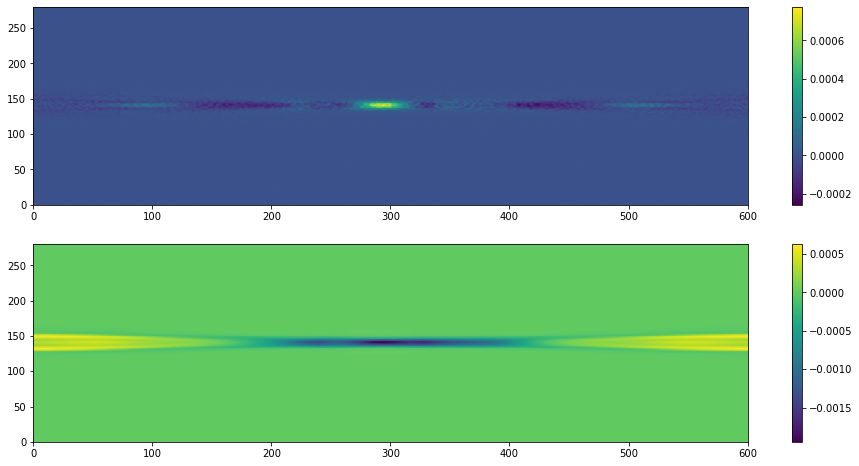

In [275]:
k = div_qyy / (vt*(pyy.reshape(zshape,xshape) - P_avg))
k = k[np.logical_not(np.isnan(k))].mean()
# k=0.0025
fig, axes = plt.subplots(2,1)
pcm0 = axes[0].pcolormesh(div_qyy)
fig.colorbar(pcm0, ax=axes[0])
pcm1 = axes[1].pcolormesh(vt*k*P_closure_y )
fig.colorbar(pcm1, ax=axes[1])
k

-0.6128705517187267

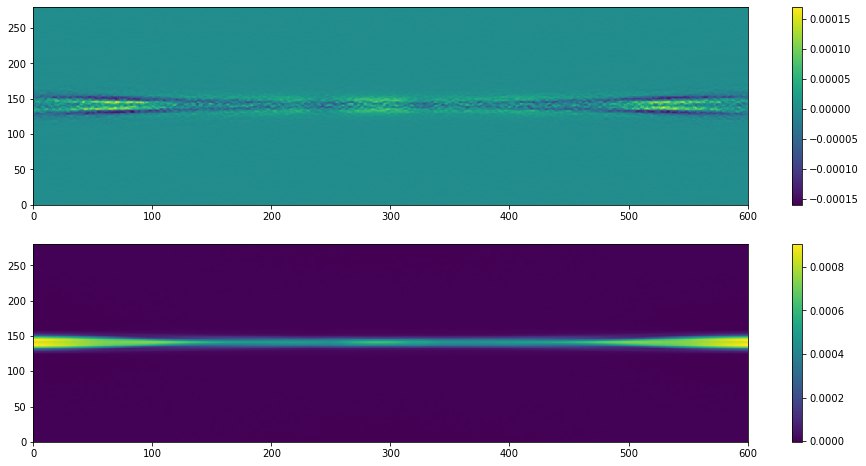

In [276]:
# k = div_qzz / (vt*(pzz.reshape(zshape,xshape) - P_avg))
# k = k[np.logical_not(np.isnan(k))].mean()
# k = -0.0064
fig, axes = plt.subplots(2,1)
pcm0 = axes[0].pcolormesh(div_qzz)
fig.colorbar(pcm0, ax=axes[0])
pcm1 = axes[1].pcolormesh(vt*k*P_closure_z )
fig.colorbar(pcm1, ax=axes[1])
k

In [277]:
closure_regressor = LstsqThresholdRegressor(lthreshold=0., uthreshold=1e6, scaling=False)
jx = prep('jx_nc_e', time)
jy = prep('jy_nc_e', time)
jz = prep('jz_nc_e', time)
ex = h5p.getH5Grid('ex_ec', time).data[:,0,:]
ey = h5p.getH5Grid('ey_ec', time).data[:,0,:]
ez = h5p.getH5Grid('ez_ec', time).data[:,0,:]
Ex = averaging(ec_to_nc(ex, dim='x'))[cut:-cut,cut:-cut].flatten()
Ey = averaging(ec_to_nc(ey, dim='y'))[cut:-cut,cut:-cut].flatten()
Ez = averaging(ec_to_nc(ez, dim='z'))[cut:-cut,cut:-cut].flatten()
closure_library = np.vstack((
                            vt*P_rotated[:,0,0],
                            vt*P_rotated[:,1,1],
                            vt*P_rotated[:,2,2],)).T
#                             vt*P_matrix[:,0,0],
#                             vt*P_matrix[:,1,1],
#                             vt*P_matrix[:,2,2],
#                             jx*Ex, jy*Ey, jz*Ez)).T

Loading jx_nc_e from File: pfd.002366.xdmf
Loading jy_nc_e from File: pfd.002366.xdmf
Loading jz_nc_e from File: pfd.002366.xdmf
Loading ex_ec from File: pfd.002366.xdmf
Loading ey_ec from File: pfd.002366.xdmf
Loading ez_ec from File: pfd.002366.xdmf


final MSE:
	 [5.30170257e-10]
Weights:
	 Term 0: [-0.03496608]
	 Term 1: [0.03269936]
	 Term 2: [0.00241416]


(60000.0, 120000.0)

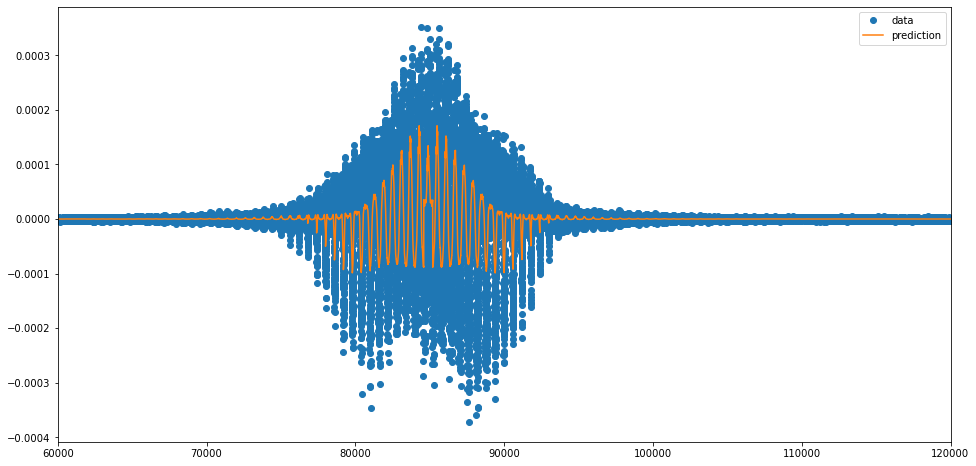

In [278]:
y = div_qxx.flatten() 

closure_regressor.fit(closure_library, y)

plt.xlim(60000,120000)

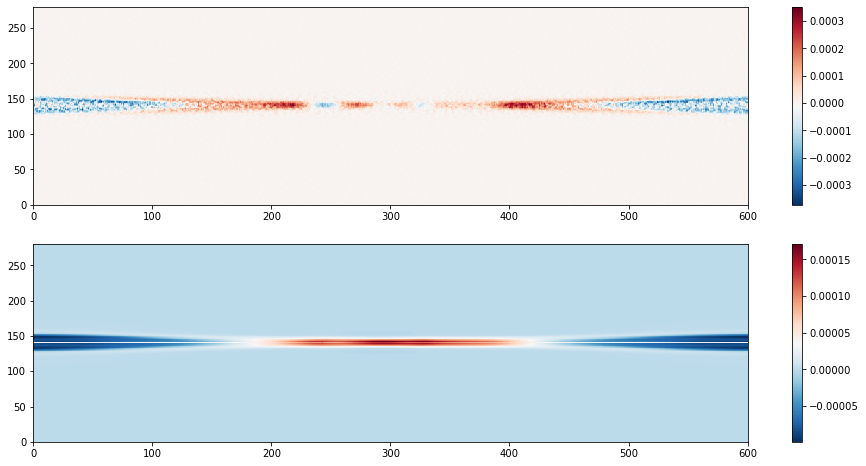

In [279]:
fig, axes = plt.subplots(2,1)
pcm0 = axes[0].pcolormesh(div_qxx, cmap='RdBu_r')
fig.colorbar(pcm0, ax=axes[0])
pcm1 = axes[1].pcolormesh(closure_regressor.predict(closure_library).reshape(zshape,xshape), cmap='RdBu_r')
fig.colorbar(pcm1, ax=axes[1])

final MSE:
	 [5.41116517e-10]
Weights:
	 Term 0: [-0.01230728]
	 Term 1: [0.02541126]
	 Term 2: [-0.01789419]


(60000.0, 120000.0)

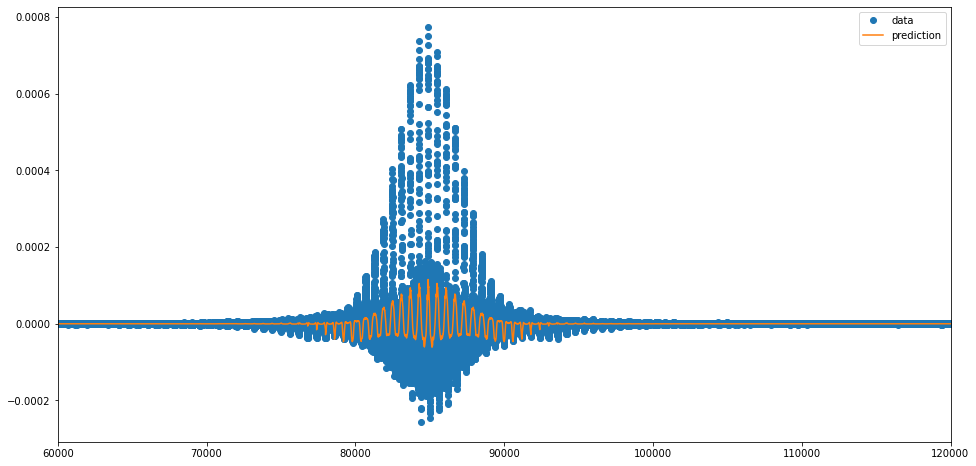

In [280]:
y = div_qyy.flatten() #div_q_xx.flatten()

closure_regressor.fit(closure_library, y)

plt.xlim(60000,120000)


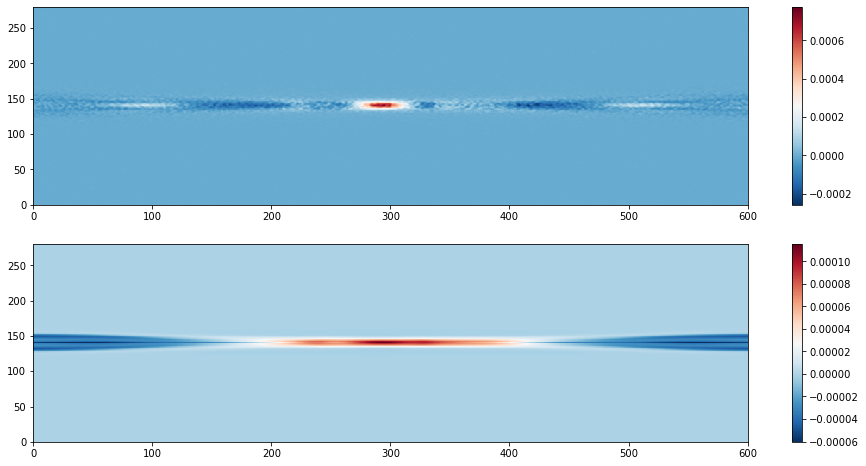

In [281]:
fig, axes = plt.subplots(2,1)
pcm0 = axes[0].pcolormesh(div_qyy, cmap='RdBu_r')
fig.colorbar(pcm0, ax=axes[0])
pcm1 = axes[1].pcolormesh(closure_regressor.predict(closure_library).reshape(zshape,xshape), cmap='RdBu_r')
fig.colorbar(pcm1, ax=axes[1])

final MSE:
	 [1.82536052e-10]
Weights:
	 Term 0: [0.00838707]
	 Term 1: [0.00118744]
	 Term 2: [-0.01233907]


(60000.0, 120000.0)

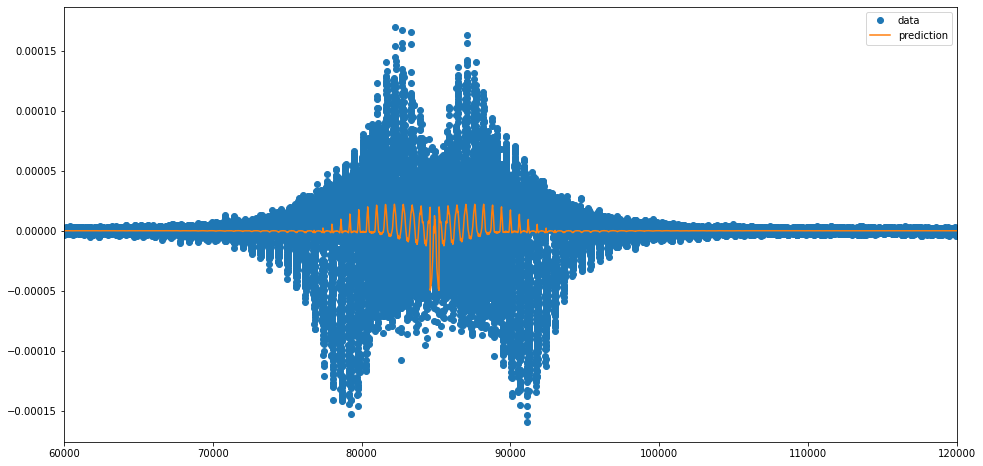

In [282]:
y = div_qzz.flatten() #div_q_xx.flatten()

closure_regressor.fit(closure_library, y)

plt.xlim(60000,120000)


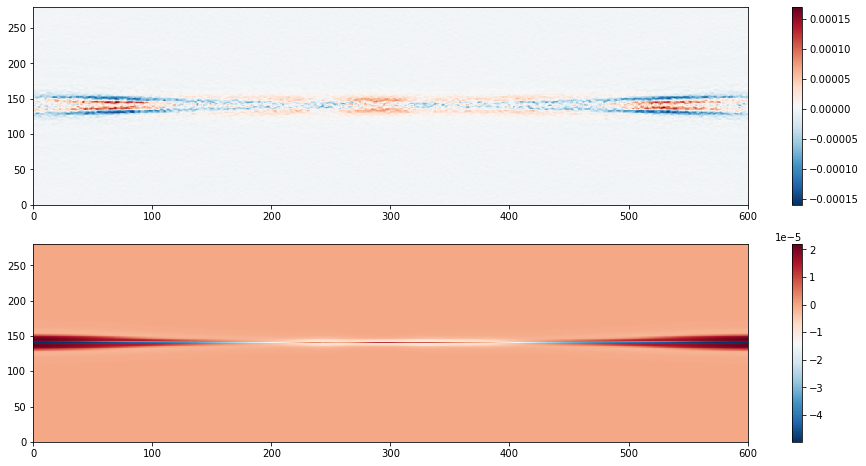

In [283]:
fig, axes = plt.subplots(2,1)
pcm0 = axes[0].pcolormesh(div_qzz, cmap='RdBu_r')
fig.colorbar(pcm0, ax=axes[0])
pcm1 = axes[1].pcolormesh(closure_regressor.predict(closure_library).reshape(zshape,xshape), cmap='RdBu_r')
fig.colorbar(pcm1, ax=axes[1])

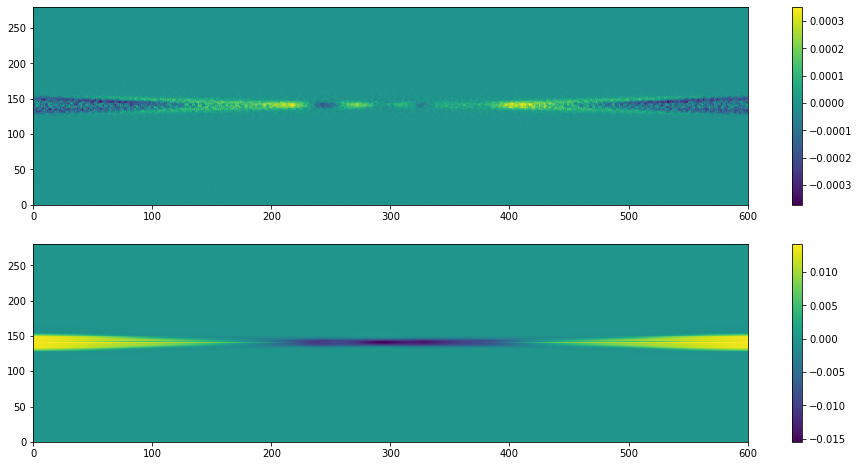

In [284]:
P_rot_avg = 1/3*(P_rotated[...,0,0] + P_rotated[...,1,1] + P_rotated[...,2,2])
P00_rotated = P_rotated[...,0,0] - P_rot_avg
P11_rotated = P_rotated[...,1,1] - P_rot_avg
P22_rotated = P_rotated[...,2,2] - P_rot_avg
P_closure_rotated = np.zeros(B_matrix.shape)
P_closure_rotated[...,0,0] = P00_rotated
P_closure_rotated[...,1,1] = P11_rotated
P_closure_rotated[...,2,2] = P22_rotated
P_closure_unrotated = B_matrix @ P_closure_rotated @ np.transpose(B_matrix, (0,2,1))
fig, axes = plt.subplots(2,1)
pcm0 = axes[0].pcolormesh(div_qxx)
fig.colorbar(pcm0, ax=axes[0])
pcm1 = axes[1].pcolormesh(P_closure_unrotated[...,0,0].reshape(zshape,xshape))
fig.colorbar(pcm1, ax=axes[1])

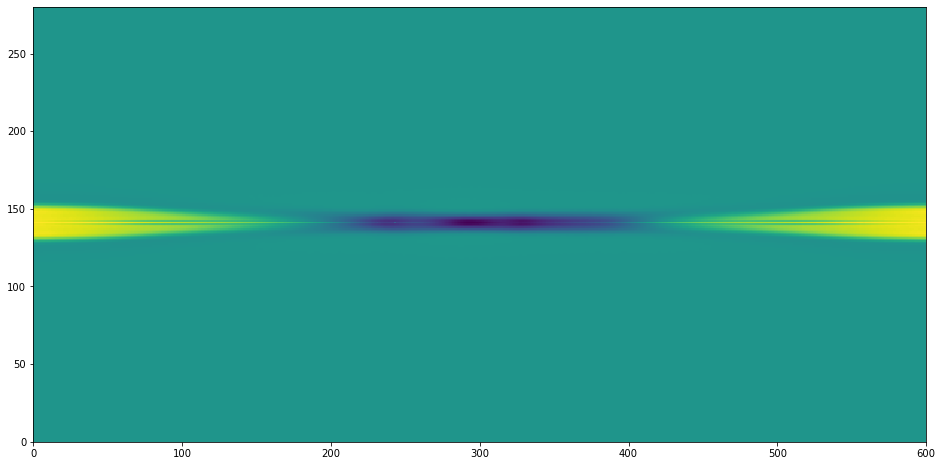

In [327]:
plt.pcolormesh(P_closure_unrotated[...,0,0].reshape(zshape,xshape))


In [285]:
#### Work with cropped box around x-point
#### Allows us reduce the number of zeros in the background so that the MSE is now meaningful

div_qxx_crop = div_qxx[120:165,200:400]
div_qyy_crop = div_qyy[120:165,200:400]
div_qzz_crop = div_qzz[120:165,200:400]

jx_c = prep('jx_nc_e', time).reshape(zshape,xshape)
jy_c = prep('jy_nc_e', time).reshape(zshape,xshape)
jz_c = prep('jz_nc_e', time).reshape(zshape,xshape)

Ex_c = averaging(ec_to_nc(ex, dim='x'))[cut:-cut,cut:-cut]
Ey_c = averaging(ec_to_nc(ey, dim='y'))[cut:-cut,cut:-cut]
Ez_c = averaging(ec_to_nc(ez, dim='z'))[cut:-cut,cut:-cut]
Bx_c = averaging(ec_to_nc(bx, dim='x'))[cut:-cut,cut:-cut]
By_c = averaging(ec_to_nc(by, dim='y'))[cut:-cut,cut:-cut]
Bz_c = averaging(ec_to_nc(bz, dim='z'))[cut:-cut,cut:-cut]
jx_c = jx_c[120:165,200:400].flatten()
jy_c = jy_c[120:165,200:400].flatten()
jz_c = jz_c[120:165,200:400].flatten()
Ex_c = Ex_c[120:165,200:400]
Ey_c = Ey_c[120:165,200:400]
Ez_c = Ez_c[120:165,200:400]
Bx_c = Bx_c[120:165,200:400]
By_c = By_c[120:165,200:400]
Bz_c = Bz_c[120:165,200:400]


d_EyBz_dx = (np.diff(Ey_c*Bz_c, axis=1, prepend=0) + np.diff(Ey_c*Bz_c, axis=1, append=0))[cut:-cut,cut:-cut] / dx / 2
d_EzBy_dx = (np.diff(Ez_c*By_c, axis=1, prepend=0) + np.diff(Ez_c*By_c, axis=1, append=0))[cut:-cut,cut:-cut] / dx / 2
d_ExBy_dz = (np.diff(Ex_c*By_c, axis=0, prepend=0) + np.diff(Ex_c*By_c, axis=0, append=0))[cut:-cut,cut:-cut] / dz / 2
d_EyBx_dz = (np.diff(Ey_c*Bx_c, axis=0, prepend=0) + np.diff(Ey_c*Bx_c, axis=0, append=0))[cut:-cut,cut:-cut] / dz / 2
Ex_c = Ex_c.flatten()
Ey_c = Ey_c.flatten()
Ez_c = Ez_c.flatten()
Bx_c = Bx_c.flatten()
By_c = By_c.flatten()
Bz_c = Bz_c.flatten()
d_EyBz_dx = d_EyBz_dx.flatten()
d_EzBy_dx = d_EzBy_dx.flatten()
d_ExBy_dz = d_ExBy_dz.flatten()
d_EyBx_dz = d_EyBx_dz.flatten()

Loading jx_nc_e from File: pfd.002366.xdmf
Loading jy_nc_e from File: pfd.002366.xdmf
Loading jz_nc_e from File: pfd.002366.xdmf


In [286]:
closure_regressor = LstsqThresholdRegressor(lthreshold=0., uthreshold=1e6, scaling=False)

closure_library = np.vstack((
#                         (d_EyBz_dx - d_EzBy_dx)[120:165,200:400].flatten(),
#                         (d_ExBy_dz - d_EyBx_dz)[120:165,200:400].flatten(),
#                             vt*P_matrix_img[120:165,200:400,0,0].flatten(),
#                             vt*P_matrix_img[120:165,200:400,1,1].flatten(),
#                             vt*P_matrix_img[120:165,200:400,2,2].flatten(),
                            vt*P_rotated_img[120:165,200:400,0,0].flatten(),
                            vt*P_rotated_img[120:165,200:400,1,1].flatten(),
                            vt*P_rotated_img[120:165,200:400,2,2].flatten(),
                            jx_c*Ex_c, jy_c*Ey_c, jz_c*Ez_c)).T

## My thought is to use the rotated P. It is silly to think that each direction should have the same k, why not k_par, k_perp
## or use x,y,z and average the k from each div_qii in each direction to get kx, ky, kz

final MSE:
	 [1.27510355e-09]
Weights:
	 Term 0: [0.05618074]
	 Term 1: [-0.0557903]
	 Term 2: [0.07132459]
	 Term 3: [-0.14371406]
	 Term 4: [0.43940568]
	 Term 5: [0.61552109]


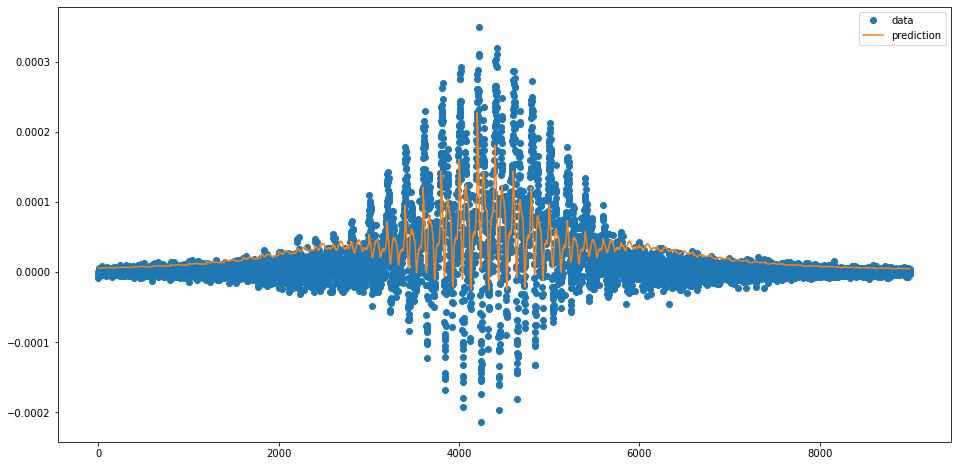

In [287]:
y = div_qxx_crop.flatten()

closure_regressor.fit(closure_library, y)


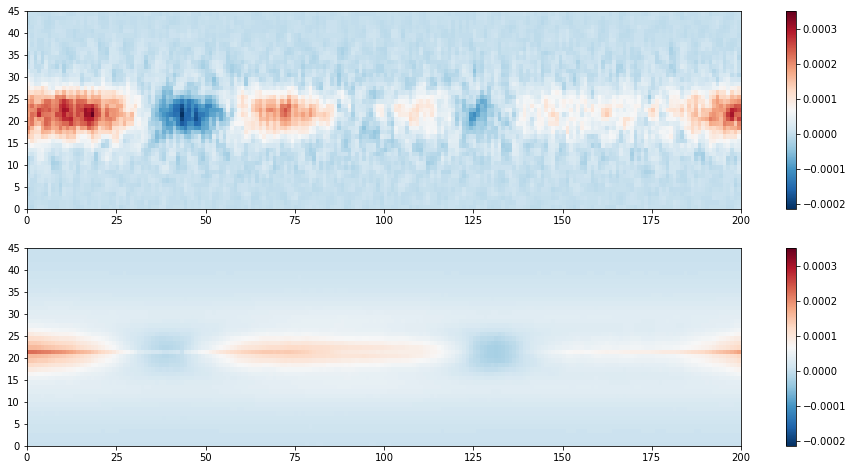

In [288]:
fig, axes = plt.subplots(2,1)
pcm0 = axes[0].pcolormesh(div_qxx_crop, cmap='RdBu_r')
fig.colorbar(pcm0, ax=axes[0])
pcm1 = axes[1].pcolormesh(closure_regressor.predict(closure_library).reshape(45,200), cmap='RdBu_r', vmin=y.min(), vmax=y.max())
fig.colorbar(pcm1, ax=axes[1])

final MSE:
	 [9.8840814e-10]
Weights:
	 Term 0: [-0.02235866]
	 Term 1: [-0.00764198]
	 Term 2: [-0.03445528]
	 Term 3: [2.27842223]
	 Term 4: [1.4080634]
	 Term 5: [0.10519474]


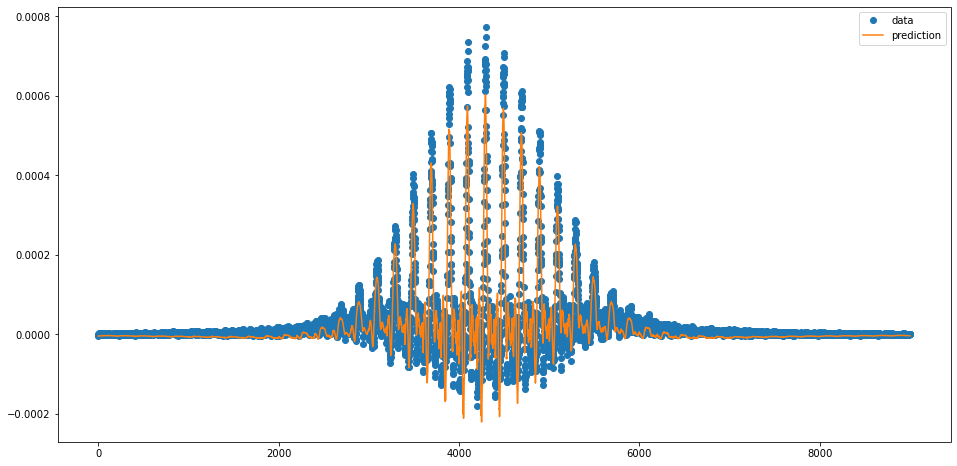

In [289]:
y = div_qyy_crop.flatten()

closure_regressor.fit(closure_library, y)


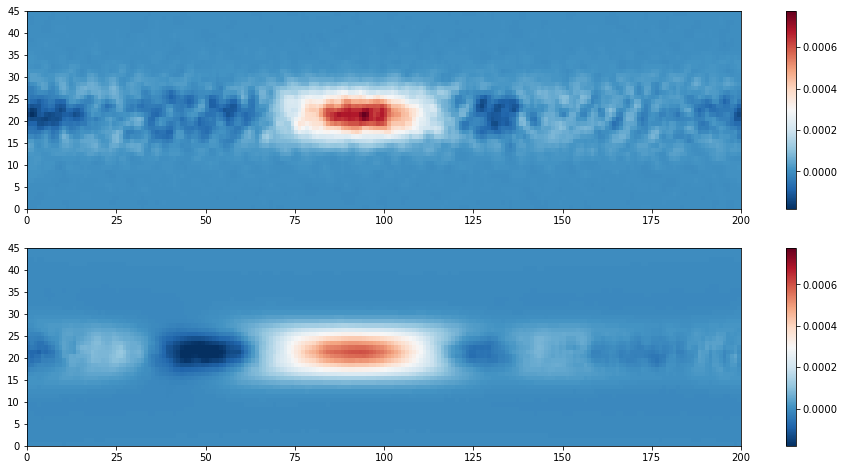

In [290]:
fig, axes = plt.subplots(2,1)
pcm0 = axes[0].pcolormesh(div_qyy_crop, cmap='RdBu_r')
fig.colorbar(pcm0, ax=axes[0])
pcm1 = axes[1].pcolormesh(closure_regressor.predict(closure_library).reshape(45,200), cmap='RdBu_r', vmin=y.min(), vmax=y.max())
fig.colorbar(pcm1, ax=axes[1])

final MSE:
	 [3.34736635e-10]
Weights:
	 Term 0: [0.03611758]
	 Term 1: [-0.03532655]
	 Term 2: [0.02989274]
	 Term 3: [0.45948204]
	 Term 4: [0.24731677]
	 Term 5: [-0.20223204]


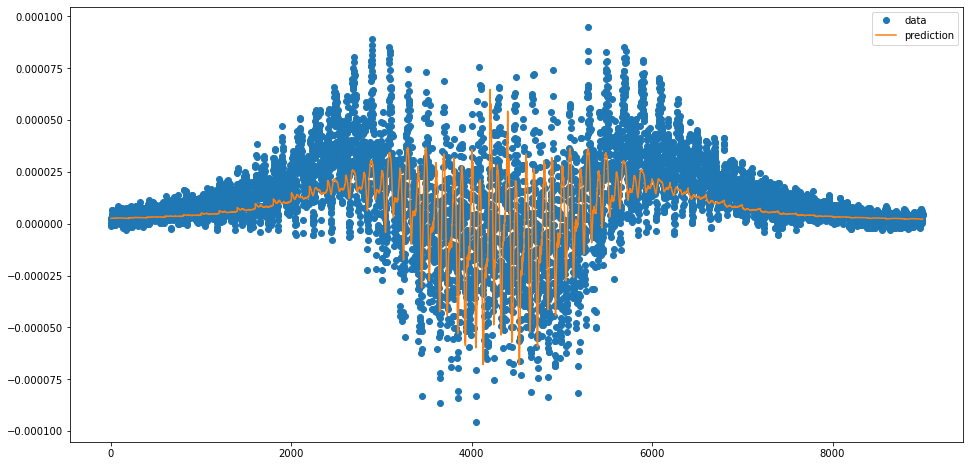

In [291]:
y = div_qzz_crop.flatten()

closure_regressor.fit(closure_library, y)


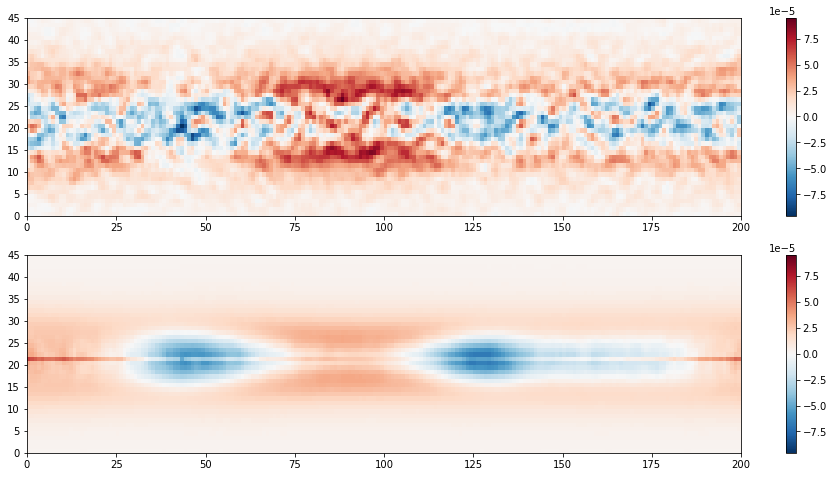

In [292]:
fig, axes = plt.subplots(2,1)
pcm0 = axes[0].pcolormesh(div_qzz_crop, cmap='RdBu_r')
fig.colorbar(pcm0, ax=axes[0])
pcm1 = axes[1].pcolormesh(closure_regressor.predict(closure_library).reshape(45,200), cmap='RdBu_r', vmin=y.min(), vmax=y.max())
fig.colorbar(pcm1, ax=axes[1])

In [293]:
def mse(A, B):
    return np.linalg.norm(A - B)**2/A.size 
k_guess = 1#0.1
P_closure_x_crop = P_closure_x[120:165,200:400]
P_closure_y_crop = P_closure_y[120:165,200:400]
P_closure_z_crop = P_closure_z[120:165,200:400]

mse(div_qxx_crop, vt*k_guess*P_closure_x_crop), mse(div_qyy_crop, vt*k_guess*P_closure_y_crop), mse(div_qzz_crop, vt*k_guess*P_closure_z_crop)

(3.5161013623407213e-07, 7.514312743858104e-07, 1.2873077913653558e-07)

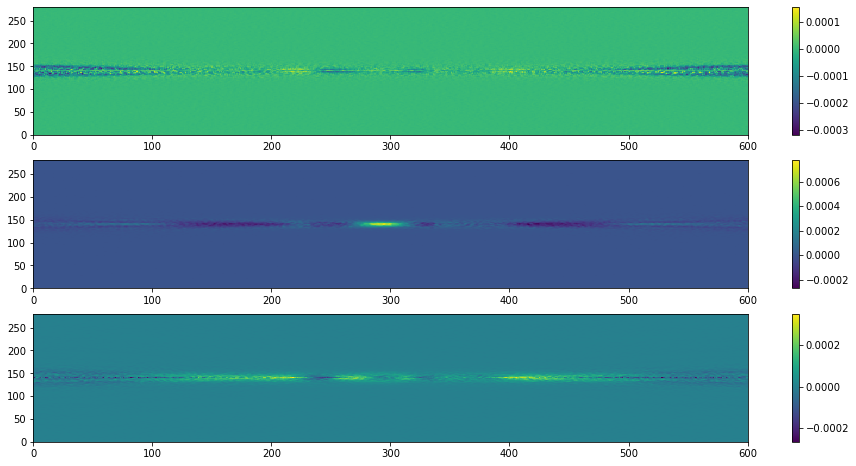

In [294]:
## Rotate everything into B_par B_perp1/2 directions and redo
## T
div_qii_matrix_x = np.stack((div_qxx.flatten(), div_qxy.flatten(), div_qxz.flatten()), -1)
div_qii_matrix_y = np.stack((div_qxy.flatten(), div_qyy.flatten(), div_qyz.flatten()), -1)
div_qii_matrix_z = np.stack((div_qxz.flatten(), div_qyz.flatten(), div_qzz.flatten()), -1)
div_qii_matrix = np.stack((div_qii_matrix_x, div_qii_matrix_y, div_qii_matrix_z), -1)
# div_qii_matrix = np.zeros(B_matrix.shape)
# div_qii_matrix[...,0,0] = div_qxx.flatten()
# div_qii_matrix[...,1,1] = div_qyy.flatten()
# div_qii_matrix[...,2,2] = div_qzz.flatten()
div_qii_rotated = np.transpose(B_matrix, (0,2,1))@div_qii_matrix@B_matrix
div_qii_rotated_img = div_qii_rotated.reshape(zshape,xshape, 3, 3)

fig, axes = plt.subplots(3,1)
pcm0 = axes[0].pcolormesh(div_qii_rotated_img[...,0,0])
fig.colorbar(pcm0, ax=axes[0])
pcm1 = axes[1].pcolormesh(div_qii_rotated_img[...,1,1])
fig.colorbar(pcm1, ax=axes[1])
pcm2 = axes[2].pcolormesh(div_qii_rotated_img[...,2,2])
fig.colorbar(pcm2, ax=axes[2])

In [295]:
JE_matrix = np.zeros(B_matrix.shape)
JE_matrix[...,0,0] = (jx*Ex).flatten()
JE_matrix[...,1,1] = (jy*Ey).flatten()
JE_matrix[...,2,2] = (jz*Ez).flatten()
JE_rotated = np.transpose(B_matrix, (0,2,1)) @ JE_matrix @ B_matrix

closure_regressor = LstsqThresholdRegressor(lthreshold=0., uthreshold=1e6, scaling=False)

closure_library = np.vstack((
                            vt*P_rotated[:,0,0],
                            vt*P_rotated[:,1,1],
                            vt*P_rotated[:,2,2],
                            JE_rotated[:,0,0],
                            JE_rotated[:,1,1],
                            JE_rotated[:,2,2],
                    )).T


final MSE:
	 [2.13101453e-10]
Weights:
	 Term 0: [-0.02213685]
	 Term 1: [0.00716211]
	 Term 2: [0.00577397]
	 Term 3: [0.26663425]
	 Term 4: [0.02176884]
	 Term 5: [0.36908496]


(60000.0, 120000.0)

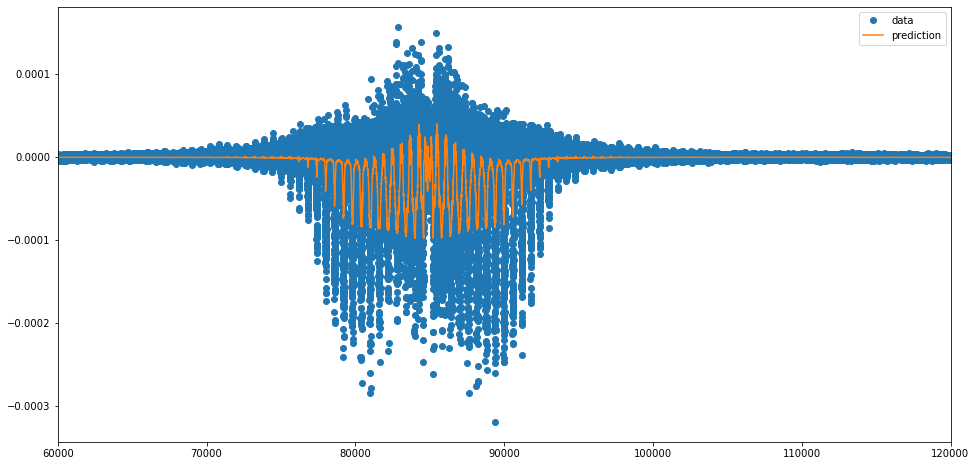

In [296]:
y = div_qii_rotated[...,0,0] 

closure_regressor.fit(closure_library, y)

plt.xlim(60000,120000)

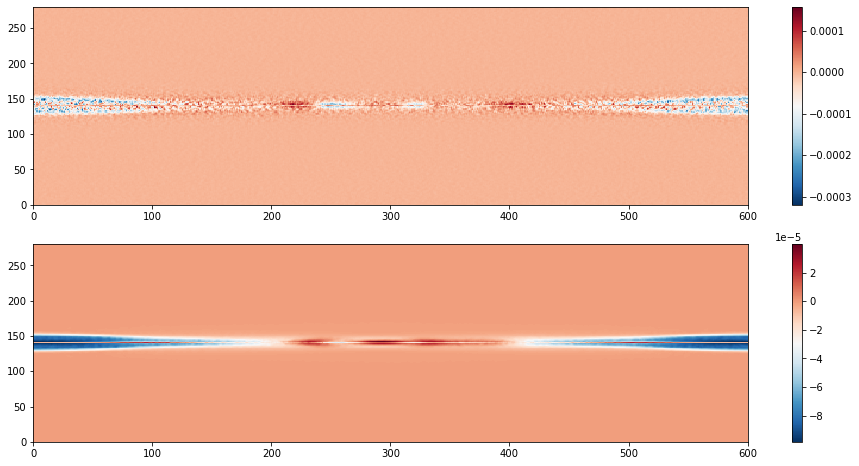

In [297]:
fig, axes = plt.subplots(2,1)
pcm0 = axes[0].pcolormesh(div_qii_rotated_img[...,0,0], cmap='RdBu_r')
fig.colorbar(pcm0, ax=axes[0])
pcm1 = axes[1].pcolormesh(closure_regressor.predict(closure_library).reshape(zshape,xshape), cmap='RdBu_r')
fig.colorbar(pcm1, ax=axes[1])

final MSE:
	 [2.31995774e-10]
Weights:
	 Term 0: [0.00497525]
	 Term 1: [-0.03376174]
	 Term 2: [0.0091585]
	 Term 3: [2.56001449]
	 Term 4: [1.46666632]
	 Term 5: [2.27243516]


(60000.0, 120000.0)

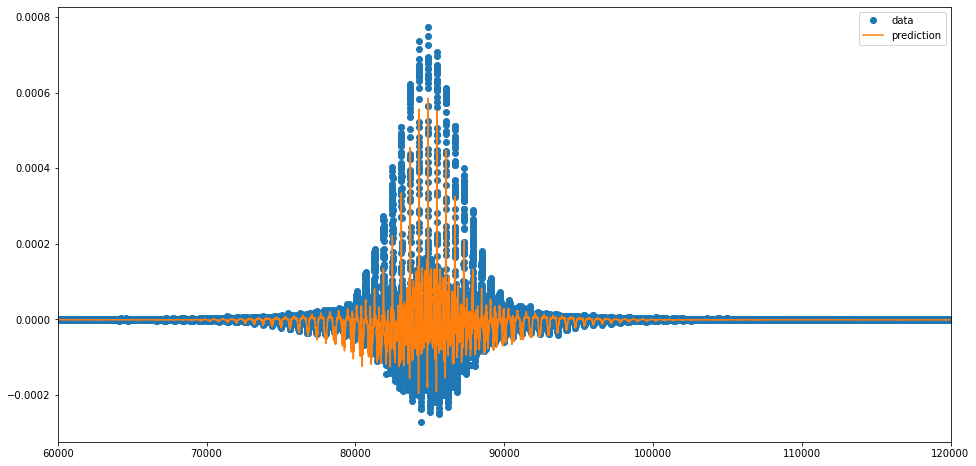

In [298]:
y = div_qii_rotated[...,1,1] 

closure_regressor.fit(closure_library, y)

plt.xlim(60000,120000)

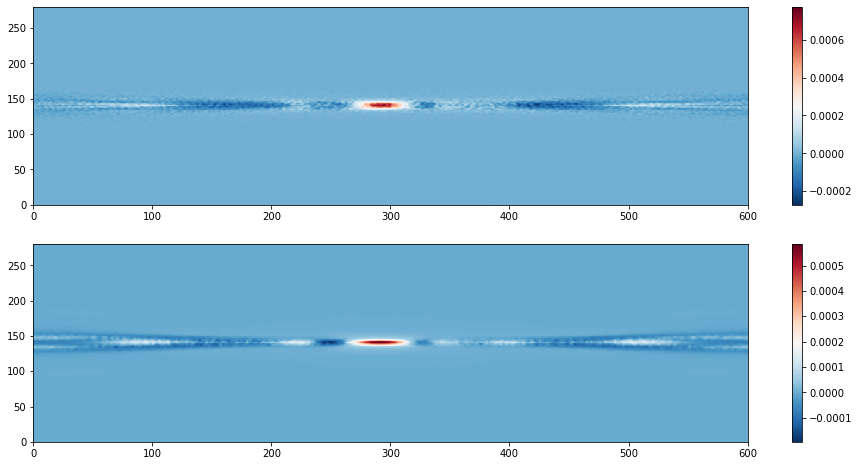

In [299]:
fig, axes = plt.subplots(2,1)
pcm0 = axes[0].pcolormesh(div_qii_rotated_img[...,1,1], cmap='RdBu_r')
fig.colorbar(pcm0, ax=axes[0])
pcm1 = axes[1].pcolormesh(closure_regressor.predict(closure_library).reshape(zshape,xshape), cmap='RdBu_r')
fig.colorbar(pcm1, ax=axes[1])

final MSE:
	 [1.79305678e-10]
Weights:
	 Term 0: [0.00517566]
	 Term 1: [0.00062301]
	 Term 2: [-0.0024955]
	 Term 3: [-1.60141028]
	 Term 4: [0.20648082]
	 Term 5: [-1.19989301]


(60000.0, 120000.0)

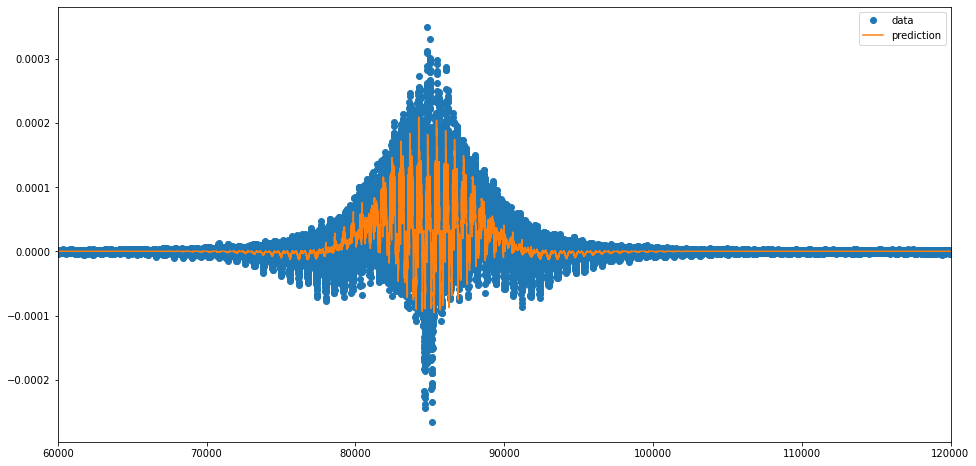

In [300]:
y = div_qii_rotated[...,2,2] 

closure_regressor.fit(closure_library, y)

plt.xlim(60000,120000)

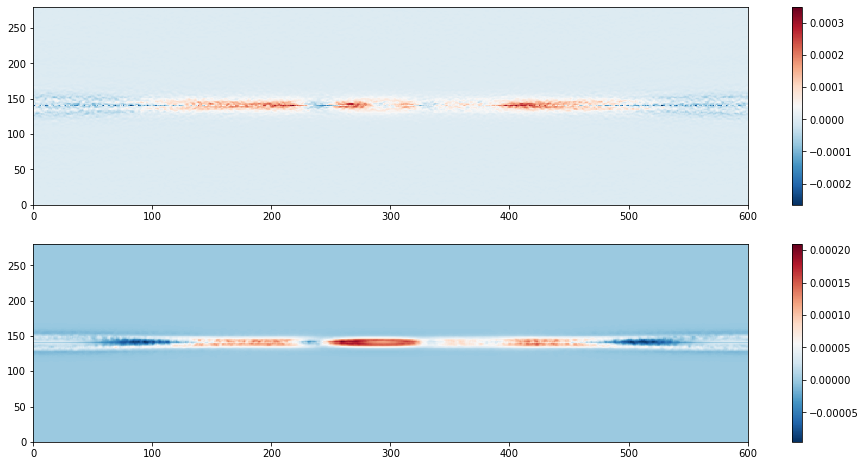

In [301]:
fig, axes = plt.subplots(2,1)
pcm0 = axes[0].pcolormesh(div_qii_rotated_img[...,2,2], cmap='RdBu_r')
fig.colorbar(pcm0, ax=axes[0])
pcm1 = axes[1].pcolormesh(closure_regressor.predict(closure_library).reshape(zshape,xshape), cmap='RdBu_r')
fig.colorbar(pcm1, ax=axes[1])

In [316]:
## repeat rotated with cropped 
closure_regressor = LstsqThresholdRegressor(lthreshold=0., uthreshold=1e6, scaling=False)
JE_rotated_img = JE_rotated.reshape(zshape,xshape,3,3)
div_qii_rotated_crop = div_qii_rotated_img[120:165,200:400,...]
closure_library = np.vstack((
                            vt*P_rotated_img[120:165,200:400,0,0].flatten(),
                            vt*P_rotated_img[120:165,200:400,1,1].flatten(),
                            vt*P_rotated_img[120:165,200:400,2,2].flatten(),
                            JE_rotated_img[120:165,200:400,0,0].flatten(),
                            JE_rotated_img[120:165,200:400,1,1].flatten(),
                            JE_rotated_img[120:165,200:400,2,2].flatten(),
                    )).T

final MSE:
	 [3.93934979e-10]
Weights:
	 Term 0: [0.02698254]
	 Term 1: [-0.02137445]
	 Term 2: [0.01732649]
	 Term 3: [1.7319261]
	 Term 4: [0.18508796]
	 Term 5: [0.48410433]


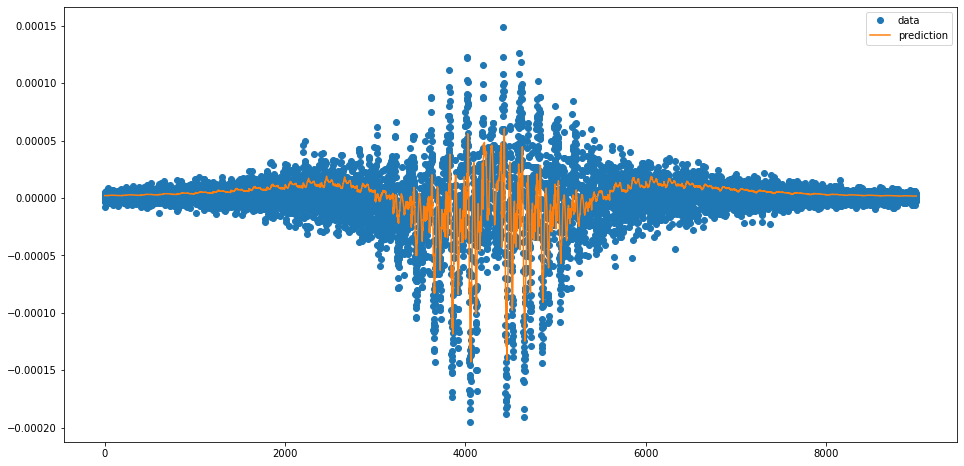

In [317]:
y = div_qii_rotated_crop[...,0,0].flatten()

closure_regressor.fit(closure_library, y)

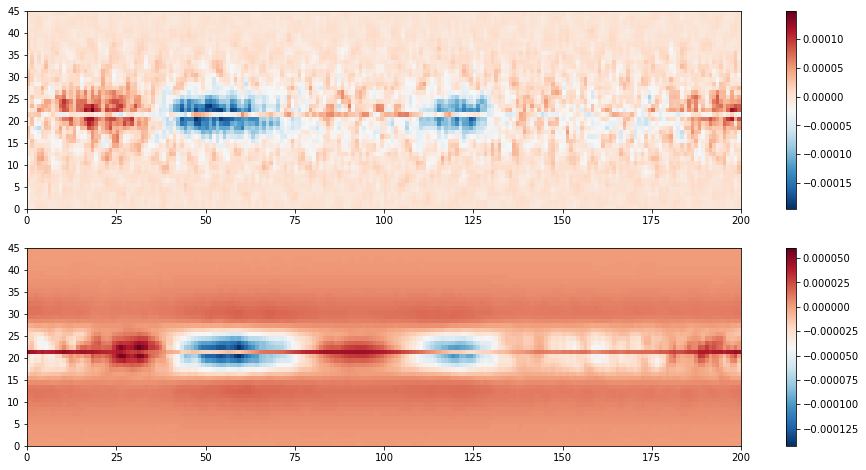

In [318]:
fig, axes = plt.subplots(2,1)
pcm0 = axes[0].pcolormesh(div_qii_rotated_crop[...,0,0], cmap='RdBu_r')
fig.colorbar(pcm0, ax=axes[0])
pcm1 = axes[1].pcolormesh(closure_regressor.predict(closure_library).reshape(45,200), cmap='RdBu_r')
fig.colorbar(pcm1, ax=axes[1])

final MSE:
	 [9.83262689e-10]
Weights:
	 Term 0: [-0.0388066]
	 Term 1: [-0.0215158]
	 Term 2: [0.00441281]
	 Term 3: [2.59366144]
	 Term 4: [1.50398009]
	 Term 5: [0.55436069]


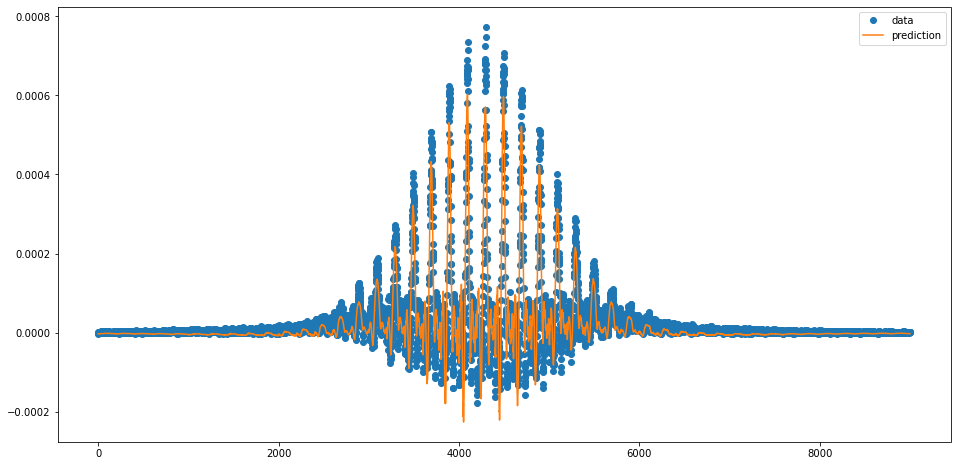

In [319]:
y = div_qii_rotated_crop[...,1,1].flatten()

closure_regressor.fit(closure_library, y)

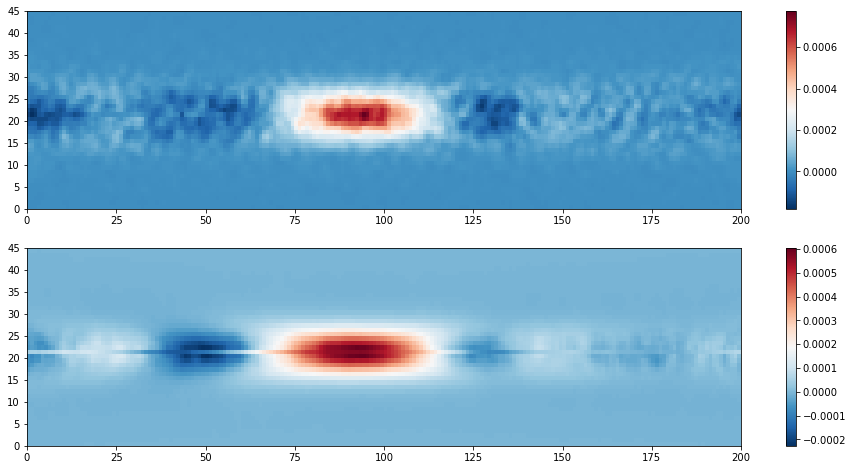

In [320]:
fig, axes = plt.subplots(2,1)
pcm0 = axes[0].pcolormesh(div_qii_rotated_crop[...,1,1], cmap='RdBu_r')
fig.colorbar(pcm0, ax=axes[0])
pcm1 = axes[1].pcolormesh(closure_regressor.predict(closure_library).reshape(45,200), cmap='RdBu_r')
fig.colorbar(pcm1, ax=axes[1])

final MSE:
	 [4.28170396e-10]
Weights:
	 Term 0: [0.06530222]
	 Term 1: [-0.06578437]
	 Term 2: [0.07681717]
	 Term 3: [-1.77190154]
	 Term 4: [0.46562202]
	 Term 5: [-0.03591631]


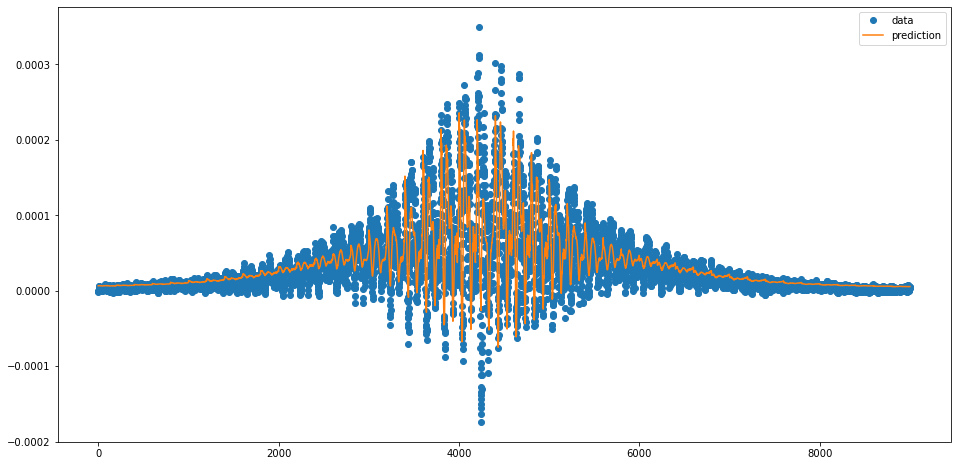

In [321]:
y = div_qii_rotated_crop[...,2,2].flatten()

closure_regressor.fit(closure_library, y)

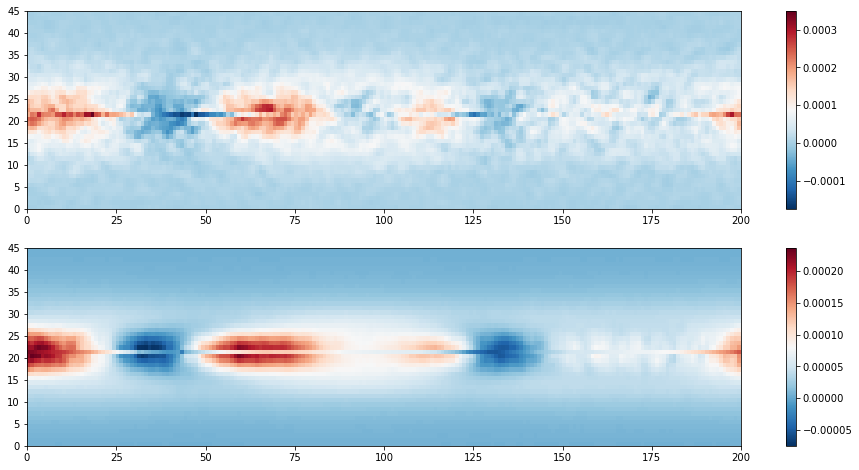

In [322]:
fig, axes = plt.subplots(2,1)
pcm0 = axes[0].pcolormesh(div_qii_rotated_crop[...,2,2], cmap='RdBu_r')
fig.colorbar(pcm0, ax=axes[0])
pcm1 = axes[1].pcolormesh(closure_regressor.predict(closure_library).reshape(45,200), cmap='RdBu_r')
fig.colorbar(pcm1, ax=axes[1])